In [4]:
from __future__ import print_function, division
%matplotlib inline

# import used packages and modules
# import display function to display the table of the pandas dataframe
from IPython.display import display

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

from scipy import signal

from hmmlearn import hmm
from seqlearn.hmm import MultinomialHMM

import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import csv




## Importing data

In [5]:
train_manchester = pd.read_csv('../data/misc/Train_Manchester_Northwich.csv')
london_data = pd.read_csv('../data/london_data/london_data.csv')

data04 = pd.read_csv('../data/meadows_december/meadows-2017-12-04.csv')
data05 = pd.read_csv('../data/meadows_december/meadows-2017-12-05.csv')

bike_data_old = pd.read_csv('../data/misc/2015061911.csv')
bike_data_feb = pd.read_csv('../data/misc/bike_feb.csv')

## Merging Data

In [6]:
bin_vals = ['bin'+str(x) for x in range(0,16)]
pm_vals = ['pm1', 'pm2_5', 'pm10']

In [7]:
# environment index is 0 as all data from these datasets is walking data
data04['environment_index'] = 0
data05['environment_index'] = 0

# environment index is 3 for bike data
bike_data_old['environment_index'] = 3
bike_data_feb['environment_index'] = 3

data = pd.concat([london_data[bin_vals+['environment_index', 'gpsLatitude', 'gpsLongitude']], 
                  train_manchester[bin_vals+['environment_index', 'gpsLatitude', 'gpsLongitude']], 
                  data04[bin_vals+['environment_index', 'gpsLatitude', 'gpsLongitude']], 
                  data05[bin_vals+['environment_index', 'gpsLatitude', 'gpsLongitude']], 
                  bike_data_old[bin_vals+['environment_index', 'gpsLatitude', 'gpsLongitude']],
                  bike_data_feb[bin_vals+['environment_index', 'gpsLatitude', 'gpsLongitude']]], ignore_index=True)

# remove indoor labelled data for this set of experiments
data = data[data['environment_index']!=7]

## Bin distribution display

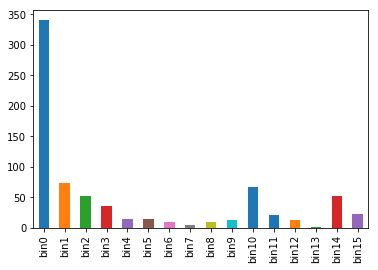

In [8]:
data[data['environment_index']==0][bin_vals].describe().loc['mean'].plot(kind='bar')

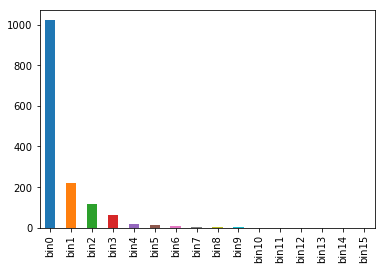

In [9]:
data[data['environment_index']==2][bin_vals].describe().loc['mean'].plot(kind='bar')

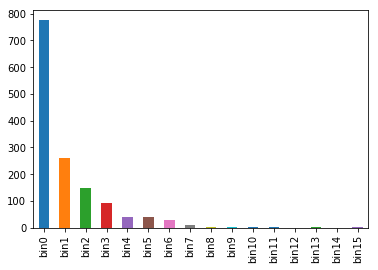

In [10]:
data[data['environment_index']==5][bin_vals].describe().loc['mean'].plot(kind='bar')

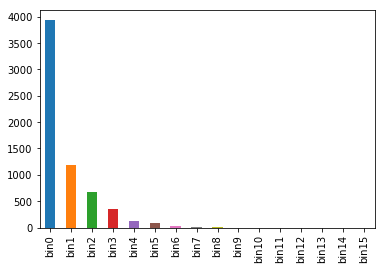

In [11]:
data[data['environment_index']==6][bin_vals].describe().loc['mean'].plot(kind='bar')

## Kmeans

In [13]:
# method to get the cluster means of the data points based on coordinates
# and the queried columns
def get_location_cluster_means(data, cluster_no, cols):
    # obtain indices of clusters
    kmeans = KMeans(n_clusters=cluster_no, random_state=0)
    # remove data rows with null coordinates
    data = data[~np.isnan(data['gpsLatitude'])]
    # get the indices of the location based clusters
    indices = kmeans.fit_predict(data[['gpsLatitude', 'gpsLongitude']])
    freqs = np.bincount(indices)
    # initialise means of queried columns
    means = np.zeros((cluster_no, len(cols)))
    # assign clustered_indices to dataframe
    data['clustered_index'] = indices
    # compute means of queried columns
    for index in np.unique(indices):
        means[index] = np.mean(data[data['clustered_index'] == index][cols])
    return means, data

In [14]:
# method to get the clusters of the environments corresponding to the 5 environments based on
# the queried columns and number of location clusters
def get_environment_clusters(data, cluster_no, cols):
    means, d = get_location_cluster_means(data, cluster_no, cols)
    # we have 5 clusters corresponding to 6 different types of transport
    environment_kmeans = KMeans(n_clusters=6, random_state=0)
    # predict the cluster indices
    environment_indices = environment_kmeans.fit_predict(means)
    # sort the indices based on the means of the clusters
    idx = np.argsort(environment_kmeans.cluster_centers_.sum(axis=1))
    lut = np.zeros_like(idx)
    lut[idx] = np.arange(6)
    # append the indices to the dataframe
    d['unsupervised_environment_index'] = lut[environment_indices][d['clustered_index']]
    return d

## Supervised Classification

In [15]:
def get_training_accuracy_with_kfolds_iloc(estimator, x_tr, y_tr, kf):
    score_array = np.empty(kf.n_folds)
    
    for (idx, (train_feature, test_feature)) in enumerate(kf):
        estimator.fit(x_tr.iloc[train_feature], y_tr.iloc[train_feature])
        y_pred = estimator.predict(x_tr.iloc[test_feature])
        score_array[idx] = accuracy_score(y_pred, y_tr.iloc[test_feature], normalize=True)
            
    return np.mean(score_array)

### Normalised Bin Values

In [16]:
data_normalised = data[data['bin0']>0].copy().reindex()
data_normalised[bin_vals] = data_normalised[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

In [19]:
# normal values
svc = SVC(kernel="rbf", gamma="auto", probability=True)
kf = KFold(len(data[bin_vals]), n_folds=3, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(svc, data[bin_vals], data['environment_index'], kf))

Accuracy: 0.539777441916


In [20]:
# normalised values
svc = SVC(kernel="rbf", gamma="auto", probability=True)
kf = KFold(len(data_normalised[bin_vals]), n_folds=3, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(svc, data_normalised[bin_vals], data_normalised['environment_index'], kf))

Accuracy: 0.584954147137


In [23]:
clustered_normalised_data = get_environment_clusters(data_normalised, 40, bin_vals)

svc = SVC(kernel="rbf", gamma="auto", probability=True)
kf = KFold(len(clustered_normalised_data), n_folds=3, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(svc, clustered_normalised_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.710138577542


In [24]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['bin0']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

svc = SVC(kernel="rbf", gamma="auto", probability=True)
kf = KFold(len(clustered_normalised_data), n_folds=3, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(svc, clustered_normalised_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.725366483255


In [25]:
# normalised values
rf = RandomForestClassifier(random_state=0, n_estimators=50, n_jobs=-1)
kf = KFold(len(data_normalised[bin_vals]), n_folds=3, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(rf, data_normalised[bin_vals], data_normalised['environment_index'], kf))

Accuracy: 0.853874057469


In [26]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['bin0']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

rf = RandomForestClassifier(random_state=0, n_estimators=50, n_jobs=-1)
kf = KFold(len(clustered_normalised_data), n_folds=3, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(rf, clustered_normalised_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.880055702738


## Neural Networks

### Default baseline: 1 layer

In [27]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)

clustered_normalised_data = get_environment_clusters(clustered_normalised_data, 40, bin_vals)

kf = KFold(len(clustered_normalised_data), n_folds=3, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, clustered_normalised_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.745830446301


In [28]:
# 25 inputs per input layer best performance
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(25,), random_state=1)

clustered_normalised_data = get_environment_clusters(clustered_normalised_data, 40, bin_vals)

kf = KFold(len(clustered_normalised_data), n_folds=3, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, clustered_normalised_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.776763806807


In [29]:
# environment clustering on raw bin values
clustered_data = get_environment_clusters(data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['bin0']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(25,), random_state=1)
kf = KFold(len(clustered_normalised_data), n_folds=3, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, clustered_normalised_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.832464506487


### Increasing number of layers

In [30]:
# environment clustering on raw bin values: 2 hidden layers
clustered_data = get_environment_clusters(data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['bin0']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(25, 25), random_state=1)
kf = KFold(len(clustered_normalised_data), n_folds=3, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, clustered_normalised_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.835793084709


In [31]:
# environment clustering on raw bin values: 3 hidden layers
clustered_data = get_environment_clusters(data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['bin0']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(25,25,25), random_state=1)
kf = KFold(len(clustered_normalised_data), n_folds=3, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, clustered_normalised_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.841035935059


In [32]:
# environment clustering on raw bin values: 4 hidden layers
clustered_data = get_environment_clusters(data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['bin0']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(25,25,25,25), random_state=1)
kf = KFold(len(clustered_normalised_data), n_folds=3, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, clustered_normalised_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.830551592962


## Changing max iterations rate

In [40]:
# environment clustering on raw bin values: 3 hidden layers
clustered_data = get_environment_clusters(data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['bin0']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-5, 
                    hidden_layer_sizes=(25,25,25), 
                    random_state=1, 
                    max_iter=500)
kf = KFold(len(clustered_normalised_data), n_folds=3, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, clustered_normalised_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.856732558929


In [41]:
# environment clustering on raw bin values: 3 hidden layers
clustered_data = get_environment_clusters(data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['bin0']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-5, 
                    hidden_layer_sizes=(25,25,25,25), 
                    random_state=1, 
                    max_iter=500)
kf = KFold(len(clustered_normalised_data), n_folds=3, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, clustered_normalised_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.861493105088


In [54]:
# environment clustering on raw bin values: 3 hidden layers
clustered_data = get_environment_clusters(data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['bin0']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-5, 
                    hidden_layer_sizes=(25,25,25,25), 
                    random_state=1, 
                    max_iter=500)
kf = KFold(len(clustered_normalised_data), n_folds=3, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, clustered_normalised_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.827225052646


## Environment Types comparison

In [ ]:
bike_data_old[bin_vals].describe().loc['mean'].plot(kind='bar')

In [ ]:
bike_data_feb[bin_vals].describe().loc['mean'].plot(kind='bar')

In [ ]:
normalised_bike_old_bins = bike_data_old[bin_vals].apply(lambda row: row/np.sum(row), axis=1)
normalised_bike_feb_bins = bike_data_feb[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

In [ ]:
normalised_bike_feb_bins.describe().loc['mean'].plot(kind='bar')
plt.title('Normalised Bin Counts For Bike on Street')
plt.show()

In [ ]:
normalised_bike_old_bins.describe().loc['mean'].plot(kind='bar')
plt.title('Normalised Bin Counts For Bike during Summer')
plt.show()

In [ ]:
bike = pd.read_csv('../data/misc/2015062518.csv')

In [ ]:
bike[bin_vals].describe().loc['mean'].plot(kind='bar')

In [ ]:
bike[bin_vals] = bike[bin_vals].apply(lambda row: row/np.sum(row), axis=1)
bike = pd.concat([bike[bin_vals], normalised_bike_feb_bins], ignore_index=True)

In [ ]:
bike[bin_vals].describe().loc['mean'].plot(kind='bar')
plt.title('Normalised Bin Counts For Bike in Feb')
plt.show()

In [ ]:
bike

In [ ]:
# absolute values for walking data from day 04
data04[bin_vals].describe().loc['mean'].plot(kind='bar')

In [ ]:
# normalised walking data from day 04
norm_walk = data04[bin_vals].apply(lambda row: row/np.sum(row), axis=1)
norm_walk.describe().loc['mean'].plot(kind='bar')
plt.title('Normalised Bin Counts For Walking Data')
plt.show()

In [ ]:
train_bins = data[data['environment_index']==2][bin_vals]
train_bins.describe().loc['mean'].plot(kind='bar')

In [ ]:
norm_train_bins = train_bins.apply(lambda row: row/np.sum(row), axis=1)
norm_train_bins.describe().loc['mean'].plot(kind='bar')
plt.title('Normalised Bin Counts For Train')
plt.show()

In [ ]:
bus_bins = data[data['environment_index']==4][bin_vals]
bus_bins.describe().loc['mean'].plot(kind='bar')

In [ ]:
norm_bus_bins = bus_bins.apply(lambda row: row/np.sum(row), axis=1)
norm_bus_bins.describe().loc['mean'].plot(kind='bar')
plt.title('Normalised Bin Counts For Bus')
plt.show()

In [ ]:
train_stationary_bins = data[data['environment_index']==5][bin_vals]
train_stationary_bins.describe().loc['mean'].plot(kind='bar')

In [ ]:
norm_train_stationary_bins = train_stationary_bins.apply(lambda row: row/np.sum(row), axis=1)
norm_train_stationary_bins.describe().loc['mean'].plot(kind='bar')
plt.title('Normalised Bin Counts For Stationary Train')
plt.show()

In [ ]:
underground_bins = data[data['environment_index']==6][bin_vals]
underground_bins.describe().loc['mean'].plot(kind='bar')

In [ ]:
norm_underground_bins = underground_bins.apply(lambda row: row/np.sum(row), axis=1)
norm_underground_bins.describe().loc['mean'].plot(kind='bar')
plt.title('Normalised Bin Counts For Subway')
plt.show()